# Tomato Leaf Disease Detection – (Cross-Domain)

**Training:** PlantVillage (Healthy + Diseased)
**Testing:** TomatoVillage (Diseased only)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TP

Mounted at /content/drive
/content/drive/MyDrive/TP


In [2]:
!pip install timm albumentations torch grad-cam lime scikit-image onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 130.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 134.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=6a56d52af42d78c95d40ab07b28a4c92d5396a2255fa496052eefc24bd9fd4be
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a84

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Dataset Paths

In [5]:
PLANT_ROOT = "/content/drive/MyDrive/TP/PlantVillage"
TOMATO_ROOT = "/content/drive/MyDrive/TP/TomatoVillage"

IMG = 224
VALID_EXT = (".jpg", ".jpeg", ".png")


In [6]:
raw_classes = sorted(os.listdir(PLANT_ROOT))

classes = [c.replace("Tomato__", "").replace("_", " ") for c in raw_classes]
NUM_CLASSES = len(raw_classes)

print("Class index mapping:")
for i, (r, c) in enumerate(zip(raw_classes, classes)):
    print(i, ":", r, "->", c)

Class index mapping:
0 : Tomato___Bacterial_spot ->  Bacterial spot
1 : Tomato___Early_blight ->  Early blight
2 : Tomato___Late_blight ->  Late blight
3 : Tomato___Leaf_Mold ->  Leaf Mold
4 : Tomato___Septoria_leaf_spot ->  Septoria leaf spot
5 : Tomato___Spider_mites Two-spotted_spider_mite ->  Spider mites Two-spotted spider mite
6 : Tomato___Target_Spot ->  Target Spot
7 : Tomato___Tomato_Yellow_Leaf_Curl_Virus ->  Tomato Yellow Leaf Curl Virus
8 : Tomato___Tomato_mosaic_virus ->  Tomato mosaic virus
9 : Tomato___healthy ->  healthy


In [7]:
def normalize_name(name):
    return (
        name.lower()
        .replace("tomato__", "")
        .replace("__", "_")
        .replace(" ", "_")
        .replace("-", "_")
        .strip("_")
    )

In [8]:
transform = A.Compose([
    A.Resize(IMG, IMG),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])

In [9]:
class PlantVillageTomatoDataset(Dataset):
    def __init__(self):
        self.samples = []
        for idx, folder in enumerate(raw_classes):
            folder_path = os.path.join(PLANT_ROOT, folder)
            for f in os.listdir(folder_path):
                if f.lower().endswith(VALID_EXT):
                    self.samples.append((os.path.join(folder_path, f), idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        image = np.array(Image.open(path).convert("RGB"))
        image = transform(image=image)["image"]
        return image, label

In [10]:
from sklearn.model_selection import train_test_split

dataset = PlantVillageTomatoDataset()
indices = np.arange(len(dataset))
labels = np.array([l for _, l in dataset.samples])

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Train samples:", len(train_idx))
print("Val samples:", len(val_idx))

Train samples: 11634
Val samples: 2909


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from tqdm import tqdm

assert train_loader is not None, "train_loader not defined"
assert NUM_CLASSES > 0, "NUM_CLASSES not defined"
assert device is not None, "device not defined"

print("Using device:", device)

model = timm.create_model(
    "densenet121",
    pretrained=True,
    num_classes=NUM_CLASSES
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for images, labels in progress:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress.set_postfix(
            loss=f"{loss.item():.4f}",
            acc=f"{100 * correct / total:.2f}%"
        )

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Loss: {epoch_loss:.4f} | "
          f"Accuracy: {epoch_acc:.2f}%")

torch.save(model.state_dict(), "teacher_densenet121.pth")
print("DenseNet121 training completed and model saved ")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Epoch 1/10: 100%|██████████| 364/364 [30:13<00:00,  4.98s/it, acc=87.12%, loss=0.1880]


Epoch [1/10] Loss: 0.4700 | Accuracy: 87.12%


Epoch 2/10: 100%|██████████| 364/364 [01:52<00:00,  3.23it/s, acc=98.28%, loss=0.0589]


Epoch [2/10] Loss: 0.0662 | Accuracy: 98.28%


Epoch 3/10: 100%|██████████| 364/364 [01:54<00:00,  3.18it/s, acc=99.36%, loss=0.0402]


Epoch [3/10] Loss: 0.0282 | Accuracy: 99.36%


Epoch 4/10: 100%|██████████| 364/364 [01:55<00:00,  3.16it/s, acc=99.58%, loss=0.0330]


Epoch [4/10] Loss: 0.0193 | Accuracy: 99.58%


Epoch 5/10: 100%|██████████| 364/364 [01:54<00:00,  3.17it/s, acc=99.64%, loss=0.0617]


Epoch [5/10] Loss: 0.0155 | Accuracy: 99.64%


Epoch 6/10: 100%|██████████| 364/364 [01:55<00:00,  3.16it/s, acc=99.89%, loss=0.1767]


Epoch [6/10] Loss: 0.0078 | Accuracy: 99.89%


Epoch 7/10: 100%|██████████| 364/364 [01:54<00:00,  3.17it/s, acc=99.74%, loss=0.0316]


Epoch [7/10] Loss: 0.0112 | Accuracy: 99.74%


Epoch 8/10: 100%|██████████| 364/364 [01:55<00:00,  3.16it/s, acc=99.55%, loss=0.0028]


Epoch [8/10] Loss: 0.0162 | Accuracy: 99.55%


Epoch 9/10: 100%|██████████| 364/364 [01:54<00:00,  3.17it/s, acc=99.79%, loss=0.0025]


Epoch [9/10] Loss: 0.0083 | Accuracy: 99.79%


Epoch 10/10: 100%|██████████| 364/364 [01:55<00:00,  3.16it/s, acc=99.91%, loss=0.0121]


Epoch [10/10] Loss: 0.0049 | Accuracy: 99.91%
DenseNet121 training completed and model saved 


In [12]:
plant_label_map = {}

for idx, folder in enumerate(raw_classes):
    norm = normalize_name(folder)
    plant_label_map[norm] = idx

print("Normalized PlantVillage labels:")
for k, v in plant_label_map.items():
    print(k, "->", v)

Normalized PlantVillage labels:
bacterial_spot -> 0
early_blight -> 1
late_blight -> 2
leaf_mold -> 3
septoria_leaf_spot -> 4
spider_mites_two_spotted_spider_mite -> 5
target_spot -> 6
tomato_yellow_leaf_curl_virus -> 7
tomato_mosaic_virus -> 8
healthy -> 9


In [13]:
class TomatoVillageDataset(Dataset):
    def __init__(self):
        self.samples = []

        for folder in os.listdir(TOMATO_ROOT):
            norm_folder = normalize_name(folder)

            if norm_folder in plant_label_map:
                label = plant_label_map[norm_folder]
                folder_path = os.path.join(TOMATO_ROOT, folder)

                for f in os.listdir(folder_path):
                    if f.lower().endswith(VALID_EXT):
                        self.samples.append(
                            (os.path.join(folder_path, f), label)
                        )

        print("TomatoVillage test samples:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        image = np.array(Image.open(path).convert("RGB"))
        image = transform(image=image)["image"]
        return image, label


test_loader = DataLoader(
    TomatoVillageDataset(),
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

TomatoVillage test samples: 1616


# CROSS-DOMAIN EVALUATION

Cross-Domain Accuracy: 0.5532178217821783

Classes present in TomatoVillage test set:
1  Early blight
2  Late blight
9  healthy

Classification Report:

               precision    recall  f1-score   support

 Early blight       0.57      0.07      0.12       496
  Late blight       0.58      0.95      0.72       904
      healthy       1.00      0.00      0.01       216

    micro avg       0.58      0.55      0.57      1616
    macro avg       0.72      0.34      0.28      1616
 weighted avg       0.63      0.55      0.44      1616



<Figure size 1200x1000 with 0 Axes>

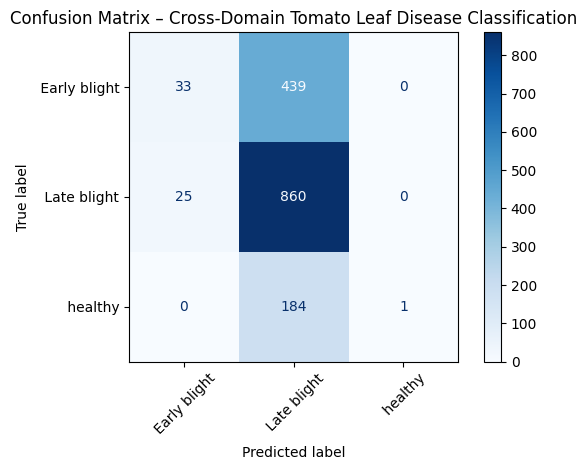

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print("Cross-Domain Accuracy:", acc)

# Handle missing classes
present_labels = sorted(np.unique(all_labels))
present_class_names = [classes[i] for i in present_labels]

print("\nClasses present in TomatoVillage test set:")
for i, name in zip(present_labels, present_class_names):
    print(i, name)

# Classification Report
print("\nClassification Report:\n")
print(
    classification_report(
        all_labels,
        all_preds,
        labels=present_labels,
        target_names=present_class_names,
        zero_division=0
    )
)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=present_labels)

plt.figure(figsize=(12,10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=present_class_names
)
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")

plt.title("Confusion Matrix – Cross-Domain Tomato Leaf Disease Classification")
plt.tight_layout()
plt.show()

In [16]:
# ResNet-50: Train + Evaluate

import torch
import torch.nn as nn
import torch.optim as optim
import timm
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# ---------- Model ----------
model = timm.create_model(
    "resnet50",
    pretrained=True,
    num_classes=NUM_CLASSES
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10

# ---------- Training ----------
for epoch in range(EPOCHS):
    model.train()
    correct, total, running_loss = 0, 0, 0.0

    progress = tqdm(train_loader, desc=f"ResNet50 Epoch {epoch+1}/{EPOCHS}")
    for images, labels in progress:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress.set_postfix(
            loss=f"{loss.item():.4f}",
            acc=f"{100*correct/total:.2f}%"
        )

    print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f}, "
          f"Train Acc={100*correct/total:.2f}%")

# ---------- Save ----------
torch.save(model.state_dict(), "resnet50_teacher.pth")
print("ResNet50 model saved")

# ---------- Cross-Domain Evaluation ----------
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print("\nResNet50 Cross-Domain Accuracy:", acc)

# Handle only classes present in test set
present_labels = sorted(np.unique(all_labels))
present_class_names = [classes[i] for i in present_labels]

print("\nResNet50 Classification Report:\n")
print(
    classification_report(
        all_labels,
        all_preds,
        labels=present_labels,
        target_names=present_class_names,
        zero_division=0
    )
)

ResNet50 Epoch 1/10: 100%|██████████| 364/364 [01:52<00:00,  3.23it/s, acc=56.32%, loss=0.3951]


Epoch 1: Loss=1.3136, Train Acc=56.32%


ResNet50 Epoch 2/10: 100%|██████████| 364/364 [01:52<00:00,  3.23it/s, acc=93.02%, loss=0.2679]


Epoch 2: Loss=0.2463, Train Acc=93.02%


ResNet50 Epoch 3/10: 100%|██████████| 364/364 [01:51<00:00,  3.27it/s, acc=97.68%, loss=0.0951]


Epoch 3: Loss=0.0862, Train Acc=97.68%


ResNet50 Epoch 4/10: 100%|██████████| 364/364 [01:51<00:00,  3.26it/s, acc=98.77%, loss=0.0199]


Epoch 4: Loss=0.0450, Train Acc=98.77%


ResNet50 Epoch 5/10: 100%|██████████| 364/364 [01:51<00:00,  3.27it/s, acc=99.20%, loss=0.0327]


Epoch 5: Loss=0.0288, Train Acc=99.20%


ResNet50 Epoch 6/10: 100%|██████████| 364/364 [01:51<00:00,  3.27it/s, acc=99.60%, loss=0.0131]


Epoch 6: Loss=0.0176, Train Acc=99.60%


ResNet50 Epoch 7/10: 100%|██████████| 364/364 [01:51<00:00,  3.27it/s, acc=99.60%, loss=0.0042]


Epoch 7: Loss=0.0148, Train Acc=99.60%


ResNet50 Epoch 8/10: 100%|██████████| 364/364 [01:51<00:00,  3.27it/s, acc=99.72%, loss=0.0021]


Epoch 8: Loss=0.0123, Train Acc=99.72%


ResNet50 Epoch 9/10: 100%|██████████| 364/364 [01:51<00:00,  3.27it/s, acc=99.85%, loss=0.0013]


Epoch 9: Loss=0.0085, Train Acc=99.85%


ResNet50 Epoch 10/10: 100%|██████████| 364/364 [01:51<00:00,  3.27it/s, acc=99.75%, loss=0.0036]


Epoch 10: Loss=0.0098, Train Acc=99.75%
ResNet50 model saved

ResNet50 Cross-Domain Accuracy: 0.530940594059406

ResNet50 Classification Report:

               precision    recall  f1-score   support

 Early blight       0.90      0.05      0.10       496
  Late blight       0.59      0.92      0.72       904
      healthy       0.00      0.00      0.00       216

    micro avg       0.59      0.53      0.56      1616
    macro avg       0.49      0.32      0.27      1616
 weighted avg       0.60      0.53      0.43      1616



In [17]:
# Architecture Comparison Table

import pandas as pd

# ---- Fill these with your actual results ----
densenet_acc = 0.4858   # DenseNet121 cross-domain accuracy
resnet_acc   = acc      # ResNet50 accuracy from previous cell

comparison_data = {
    "Architecture": ["DenseNet121", "ResNet50"],
    "Parameters (Million)": [7.97, 25.6],
    "Cross-Domain Accuracy (%)": [
        round(densenet_acc * 100, 2),
        round(resnet_acc * 100, 2)
    ]
}

df = pd.DataFrame(comparison_data)

print("Model Comparison (Cross-Domain Evaluation):\n")
display(df)

Model Comparison (Cross-Domain Evaluation):



,Architecture,Parameters (Million),Cross-Domain Accuracy (%)
0,DenseNet121,7.97,48.58
1,ResNet50,25.60,53.09


# EXPLAINABLE AI: Grad-CAM++ & LIME (2 Models)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

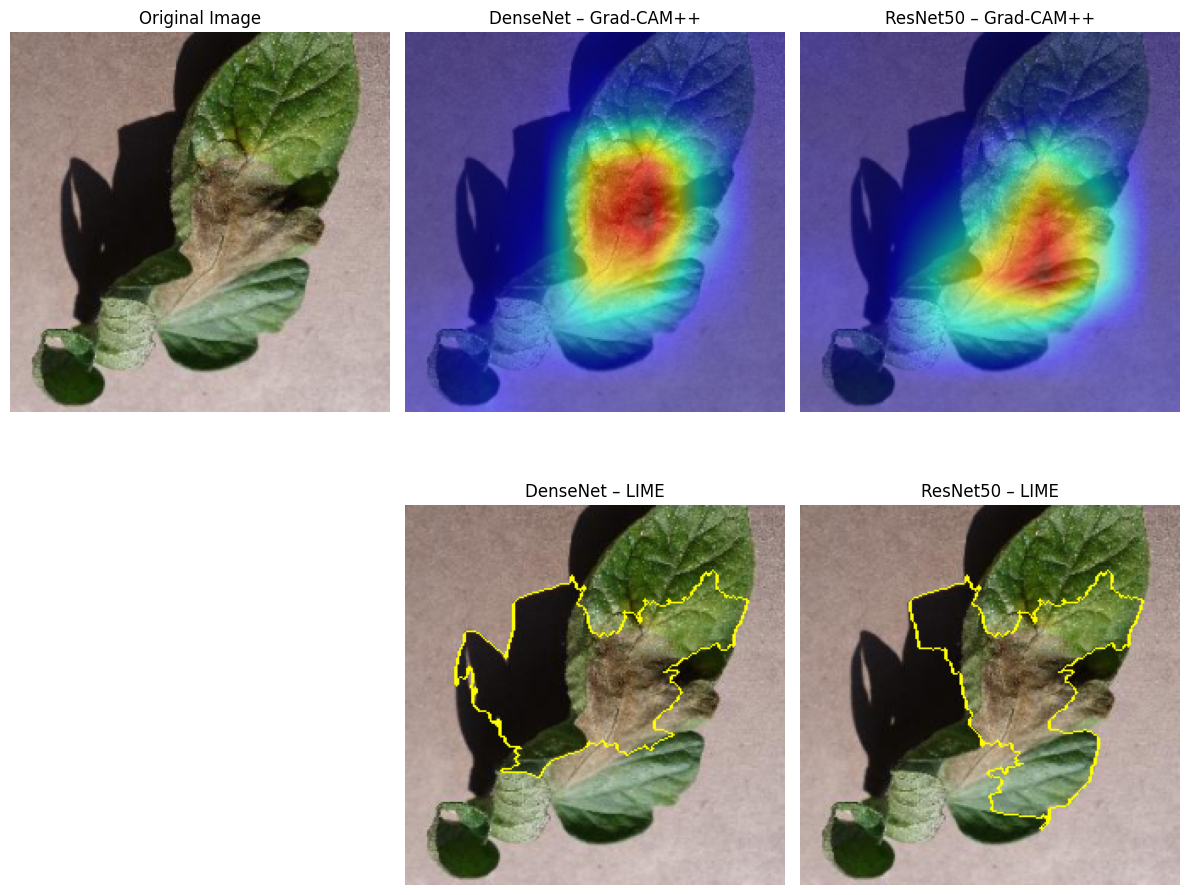

In [24]:
import torch
import timm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# ---------- Utility: load image ----------
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    return img

# ---------- Utility: LIME predictor ----------
def lime_predictor(model):
    def predict(images):
        batch = []
        for img in images:
            img = cv2.resize(img, (224,224))
            img = transform(image=img)["image"]
            batch.append(img)
        batch = torch.stack(batch).to(device)
        with torch.no_grad():
            probs = torch.softmax(model(batch), dim=1)
        return probs.cpu().numpy()
    return predict

# ---------- Load DenseNet121 ----------
densenet = timm.create_model(
    "densenet121", pretrained=False, num_classes=NUM_CLASSES
)
densenet.load_state_dict(torch.load("teacher_densenet121.pth", map_location=device))
densenet = densenet.to(device).eval()

# ---------- Load ResNet50 ----------
resnet = timm.create_model(
    "resnet50", pretrained=False, num_classes=NUM_CLASSES
)
resnet.load_state_dict(torch.load("resnet50_teacher.pth", map_location=device))
resnet = resnet.to(device).eval()

# ---------- Target layers ----------
densenet_layer = [densenet.features.norm5]
resnet_layer   = [resnet.layer4[-1]]

# ---------- Example image (change if needed) ----------
img_path = f"{PLANT_ROOT}/Tomato___Late_blight/{os.listdir(PLANT_ROOT+'/Tomato___Late_blight')[0]}"
image = load_image(img_path)
image_float = image.astype(np.float32) / 255.0
input_tensor = transform(image=image)["image"].unsqueeze(0).to(device)

# ---------- Grad-CAM++ DenseNet ----------
with GradCAMPlusPlus(model=densenet, target_layers=densenet_layer) as cam:
    cam_dense = cam(input_tensor=input_tensor)[0]
dense_cam_img = show_cam_on_image(image_float, cam_dense, use_rgb=True)

# ---------- Grad-CAM++ ResNet ----------
with GradCAMPlusPlus(model=resnet, target_layers=resnet_layer) as cam:
    cam_res = cam(input_tensor=input_tensor)[0]
res_cam_img = show_cam_on_image(image_float, cam_res, use_rgb=True)

# ---------- LIME DenseNet ----------
explainer = lime_image.LimeImageExplainer()
exp_dense = explainer.explain_instance(
    image, lime_predictor(densenet), top_labels=1, num_samples=1000
)
dense_lime, dense_mask = exp_dense.get_image_and_mask(
    exp_dense.top_labels[0], positive_only=True, num_features=5, hide_rest=False
)
dense_lime_img = mark_boundaries(dense_lime/255.0, dense_mask)

# ---------- LIME ResNet ----------
exp_res = explainer.explain_instance(
    image, lime_predictor(resnet), top_labels=1, num_samples=1000
)
res_lime, res_mask = exp_res.get_image_and_mask(
    exp_res.top_labels[0], positive_only=True, num_features=5, hide_rest=False
)
res_lime_img = mark_boundaries(res_lime/255.0, res_mask)

# ---------- Plot Results ----------
plt.figure(figsize=(12,10))

plt.subplot(2,3,1); plt.imshow(image); plt.title("Original Image"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(dense_cam_img); plt.title("DenseNet – Grad-CAM++"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(res_cam_img); plt.title("ResNet50 – Grad-CAM++"); plt.axis("off")

plt.subplot(2,3,5); plt.imshow(dense_lime_img); plt.title("DenseNet – LIME"); plt.axis("off")
plt.subplot(2,3,6); plt.imshow(res_lime_img); plt.title("ResNet50 – LIME"); plt.axis("off")

plt.tight_layout()
plt.show()

# DEPLOYMENT (ONNX Export)

In [29]:
!pip install -q onnx onnxruntime onnxruntime-tools

In [33]:
import os
import cv2
import numpy as np
from onnxruntime.quantization import (
    quantize_static,
    CalibrationDataReader,
    QuantType
)

# -------- Paths --------
FP32_MODEL = "densenet121_fp32.onnx"
INT8_MODEL = "densenet121_int8.onnx"

CALIB_DIR = f"{PLANT_ROOT}/Tomato___Late_blight"
IMG_SIZE = 224
MAX_SAMPLES = 200

# -------- Preprocess (FORCE float32) --------
def preprocess(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    img = img.astype(np.float32) / 255.0   # 🔑 float32
    img = (img - np.array([0.485, 0.456, 0.406], dtype=np.float32)) / \
          np.array([0.229, 0.224, 0.225], dtype=np.float32)

    img = np.transpose(img, (2, 0, 1))
    return np.expand_dims(img, axis=0).astype(np.float32)  # 🔑 float32

# -------- Calibration Data Reader --------
class TomatoCalibrationReader(CalibrationDataReader):
    def __init__(self, image_dir):
        self.image_paths = [
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if f.lower().endswith((".jpg", ".png"))
        ][:MAX_SAMPLES]
        self.index = 0

    def get_next(self):
        if self.index >= len(self.image_paths):
            return None

        img = preprocess(self.image_paths[self.index])
        self.index += 1
        return {"input": img}

# -------- Run INT8 Quantization --------
calib_reader = TomatoCalibrationReader(CALIB_DIR)

quantize_static(
    model_input=FP32_MODEL,
    model_output=INT8_MODEL,
    calibration_data_reader=calib_reader,
    weight_type=QuantType.QInt8,
    activation_type=QuantType.QInt8,
    per_channel=True
)

print("INT8 quantized model successfully created:")
print(INT8_MODEL)


INT8 quantized model successfully created:
densenet121_int8.onnx


In [34]:
# ADVANCED ANALYSIS & COMPARISON STATISTICS
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    cohen_kappa_score,
    matthews_corrcoef
)

# ---------- Helper function ----------
def compute_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    precision_weighted, recall_weighted, f1_weighted, support = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )

    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    return {
        "Model": model_name,
        "Accuracy (%)": round(acc * 100, 2),
        "Precision (Macro)": round(precision_macro, 3),
        "Recall (Macro)": round(recall_macro, 3),
        "F1-score (Macro)": round(f1_macro, 3),
        "Precision (Weighted)": round(precision_weighted, 3),
        "Recall (Weighted)": round(recall_weighted, 3),
        "F1-score (Weighted)": round(f1_weighted, 3),
        "Cohen Kappa": round(kappa, 3),
        "MCC": round(mcc, 3)
    }

# ---------- DenseNet statistics ----------
dense_metrics = compute_metrics(
    np.array(all_labels),
    np.array(all_preds),
    "DenseNet121"
)

results = [dense_metrics]

# ---------- Summary Table ----------
df_summary = pd.DataFrame(results)
print("MODEL COMPARISON STATISTICS\n")
display(df_summary)

# ---------- Per-class support ----------
unique_labels, counts = np.unique(all_labels, return_counts=True)
class_support = {
    "Class": [classes[i] for i in unique_labels],
    "Support (Test Samples)": counts
}

df_support = pd.DataFrame(class_support)

print("\n Class-wise Test Distribution\n")
display(df_support)

MODEL COMPARISON STATISTICS



,Model,Accuracy (%),Precision (Macro),Recall (Macro),F1-score (Macro),Precision (Weighted),Recall (Weighted),F1-score (Weighted),Cohen Kappa,MCC
0,DenseNet121,53.09,0.148,0.097,0.081,0.603,0.531,0.431,0.067,0.094



 Class-wise Test Distribution



,Class,Support (Test Samples)
0,Early blight,496
1,Late blight,904
2,healthy,216
